In [ ]:
!pip install --quiet paddlepaddle
!pip install --quiet levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.5/385.5 KB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00


In [ ]:
import os
CONFIG_ROOT = os.path.dirname("/content/")
OUTPUT_ROOT = '/content/test_output'
def full_path(sub_path, file=False):
    path = os.path.join(CONFIG_ROOT, sub_path)
    if not file and not os.path.exists(path):
        try:
            os.makedirs(path)
        except:
            print('full_path. Error makedirs',path)
    return path


def output_path(sub_path):
    path = os.path.join(OUTPUT_ROOT, sub_path)
    if not os.path.exists(path):
        try:
            os.makedirs(path)
        except:
            print('output_path. Error makedirs',path)
    return path
gpu = '0'  # None or 0,1,2...
dataset = 'test'
raw_img_dir = full_path('data/{}'.format(dataset)) 
det_model_dir  = full_path('text_detector/PaddleOCR/inference/ch_ppocr_server_v2.0_det_infer')
det_out_txt_dir = output_path('text_detector/{}/txt'.format(dataset))
det_out_viz_dir = output_path('text_detector/{}/viz_imgs'.format(dataset))
rot_drop_thresh = [.5, 2]
rot_out_img_dir = output_path('rotation_corrector/{}/imgs'.format(dataset))
rot_visualize = True
rot_model_path = full_path('rotation_corrector/weights/mobilenetv3-Epoch-487-Loss-0.03-Acc-0.99.pth', file=True)
rot_out_txt_dir = output_path('rotation_corrector/{}/txt'.format(dataset))
rot_out_viz_dir = output_path('rotation_corrector/{}/viz_imgs'.format(dataset))
cls_ocr_thres = 0.65
cls_visualize = True
cls_out_viz_dir = output_path('text_classifier/{}/viz_imgs'.format(dataset))
cls_out_txt_dir = output_path('text_classifier/{}/txt'.format(dataset))
kie_visualize = True
kie_model = full_path('key_info_extraction/PICK/saved/models/PICK_Default/test_0121_212713/model_best.pth', file=True)
kie_boxes_transcripts = output_path('key_info_extraction/{}/boxes_and_transcripts'.format(dataset))
kie_out_txt_dir = output_path('key_info_extraction/{}/txt'.format(dataset))
kie_out_viz_dir = output_path('key_info_extraction/{}/viz_imgs'.format(dataset))

!git clone https://github.com/PaddlePaddle/PaddleOCR.git
!pip install --quiet -r "/content/PaddleOCR/requirements.txt"
!wget -P {det_model_dir} https://www.dropbox.com/s/1k6u2a2enpe27w5/ch_ppocr_server_v2.0_det_infer-20230103T043843Z-001.zip +
!unzip -j {det_model_dir}/ch_ppocr_server_v2.0_det_infer-20230103T043843Z-001.zip -d {det_model_dir}
!git clone https://github.com/pbcquoc/vietocr.git
!pip install --quiet vietocr
! wget https://www.dropbox.com/s/mpi2rbk3l0cm7sj/PICKforTest.zip
!unzip PICKforTest.zip
%cd PICK
!pip install  --quiet -r requirements.txt
%cd ../
download_modelMobileNet_path = full_path('rotation_corrector/weights')
!wget -P {download_modelMobileNet_path} https://www.dropbox.com/s/ja3luaem50835x5/mobilenetv3-Epoch-487-Loss-0.03-Acc-0.99.pth +


import numpy as np
import cv2, time
from datetime import datetime
import math
from math import sqrt
from scipy.cluster.vq import kmeans, vq
import Levenshtein
import matplotlib
matplotlib.rc('font')
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import pandas as pd
from statistics import mean
# PyTorch includes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numbers
from torchvision.transforms.functional import pad
from torch.autograd import Variable
debug = False

### FUNC

In [ ]:
def euclidean_distance(pt1, pt2):
    return math.sqrt((pt1[0] - pt2[0]) * (pt1[0] - pt2[0]) + (pt1[1] - pt2[1]) * (pt1[1] - pt2[1]))
def cer_loss_one_image(sim_pred, label):
    if (max(len(sim_pred), len(label)) > 0):
        loss = Levenshtein.distance(sim_pred, label) * 1.0 / max(len(sim_pred), len(label))
    else:
        return 0
    return loss


def IoU(poly1, poly2, debug=False):
    max_w, max_h = 0, 0
    for pts in poly1.list_pts:
        if pts[0] > max_w:
            max_w = pts[0]
        if pts[1] > max_h:
            max_h = pts[1]
    for pts in poly2.list_pts:
        if pts[0] > max_w:
            max_w = pts[0]
        if pts[1] > max_h:
            max_h = pts[1]

    first_bb_points = np.array(poly1.list_pts).astype(np.int32).reshape(-1, 2)
    first_poly_mask = np.zeros((max_h, max_w)).astype(np.int32)
    cv2.fillPoly(first_poly_mask, [np.array(first_bb_points)], [255, 255, 255])

    second_bb_points = np.array(poly2.list_pts).astype(np.int32).reshape(-1, 2)
    second_poly_mask = np.zeros((max_h, max_w)).astype(np.int32)
    cv2.fillPoly(second_poly_mask, [np.array(second_bb_points)], [255, 255, 255])

    intersection = np.logical_and(first_poly_mask, second_poly_mask)
    union = np.logical_or(first_poly_mask, second_poly_mask)
    iou_score = np.sum(intersection) / np.sum(union)

    if debug and iou_score > 0.1:
        print('IoU.', iou_score, ',max_w', max_w, ', max_h', max_h)
        first_mask = np.array(first_poly_mask, dtype=np.uint8)
        cv2.imshow('1st', first_mask)
        second_mask = np.array(second_poly_mask, dtype=np.uint8)
        cv2.imshow('2nd', second_mask)

        cv2.waitKey(0)
    return iou_score


def filter_data(src_dir, dst_dir, dst_anno=None):  #filter data in dst_dir by src_dir
    list_files = get_list_file_in_folder(src_dir)
    list_files2=get_list_file_in_folder(dst_dir)
    for idx, f in enumerate(list_files2):
        if f in list_files:
            continue
        else:
            print(idx,'filter file',f)
            os.remove(os.path.join(dst_dir,f))
class poly():
    def __init__(self, segment_pts, type=1, value=''):
        if isinstance(segment_pts, str):
            segment_pts = [int(f) for f in segment_pts.split(',')]
        elif isinstance(segment_pts, list):
            segment_pts = [round(f) for f in segment_pts]
        self.type = type
        self.value = value
        num_pts = int(len(segment_pts) / 2)
        # print('num_pts', num_pts)
        first_pts = [segment_pts[0], segment_pts[1]]
        self.list_pts = [first_pts]
        for i in range(1, num_pts):
            self.list_pts.append([segment_pts[2 * i], segment_pts[2 * i + 1]])

    def reduce_pts(self, dist_thres=7):  # reduce nearly duplicate points
        last_pts = self.list_pts[0]
        filter_pts = []
        for i in range(1, len(self.list_pts)):
            curr_pts = self.list_pts[i]
            dist = euclidean_distance(last_pts, curr_pts)
            # print('distance between', i - 1, i, ':', dist)
            if dist > dist_thres:
                filter_pts.append(last_pts)
                print('Keep point', i - 1)
            last_pts = curr_pts

        # print('distance between', len(self.list_pts) - 1, 0, ':', euclidean_distance(last_pts, self.list_pts[0]))
        if euclidean_distance(last_pts, self.list_pts[0]) > dist_thres:
            filter_pts.append(last_pts)
            # print('Keep last point')

        self.list_pts = filter_pts

    def check_max_wh_ratio(self):
        max_ratio = 0
        if len(self.list_pts) == 4:
            first_edge = euclidean_distance(self.list_pts[0], self.list_pts[1])
            second_edge = euclidean_distance(self.list_pts[1], self.list_pts[2])
            if first_edge / second_edge > 1:
                long_edge = (self.list_pts[0][0] - self.list_pts[1][0], self.list_pts[0][1] - self.list_pts[1][1])
            else:
                long_edge = (self.list_pts[1][0] - self.list_pts[2][0], self.list_pts[1][1] - self.list_pts[2][1])
            max_ratio = max(first_edge / second_edge, second_edge / first_edge)
        else:
            print('check_max_wh_ratio. Polygon is not qualitareal')
        return max_ratio, long_edge

    def check_horizontal_box(self):
        if len(self.list_pts) == 4:
            max_ratio, long_edge = self.check_max_wh_ratio()
            if long_edge[0] == 0:
                angle_with_horizontal_line = 90
            else:
                angle_with_horizontal_line = math.atan2(long_edge[1], long_edge[0]) * 57.296
        else:
            print('check_horizontal_box. Polygon is not qualitareal')
        print('Angle', angle_with_horizontal_line)
        if math.fabs(angle_with_horizontal_line) > 45 and math.fabs(angle_with_horizontal_line) < 135:
            return False
        else:
            return True

    def get_horizontal_angle(self):
        assert len(self.list_pts) == 4
        max_ratio, long_edge = self.check_max_wh_ratio()
        if long_edge[0] == 0:
            if long_edge[1] < 0:
                angle_with_horizontal_line = -90
            else:
                angle_with_horizontal_line = 90
        else:
            angle_with_horizontal_line = math.atan2(long_edge[1], long_edge[0]) * 57.296
        return angle_with_horizontal_line

    def to_icdar_line(self, map_type=None):
        line_str = ''
        if len(self.list_pts) == 4:
            for pts in self.list_pts:
                line_str += '{},{},'.format(pts[0], pts[1])
            if map_type is not None:
                line_str += self.value + ',' + str(map_type[self.type])
            else:
                line_str += self.value + ',' + str(self.type)

        else:
            print('to_icdar_line. Polygon is not qualitareal')
        return line_str

In [ ]:
def get_list_file_in_folder(dir, ext=['jpg', 'png', 'JPG', 'PNG']):
    included_extensions = ext
    file_names = [fn for fn in os.listdir(dir)
                  if any(fn.endswith(ext) for ext in included_extensions)]
    return file_names

In [ ]:
type_map = {1: 'OTHER', 15: 'SELLER', 16: 'ADDRESS', 17: 'TIMESTAMP', 18: 'TOTAL_COST'}


txt_color_map = {1: 'b', 15: 'green', 16: 'blue', 17: 'm', 18: 'cyan'}
inv_type_map = {v: k for k, v in type_map.items()}

#color_map = {15: (0, 255, 0), 16: (255, 0, 0), 17: (0, 0, 255), 18: (0, 255, 255)}
inv_type_map = {v: k for k, v in type_map.items()}

def viz_output_of_pick(img_dir, output_txt_dir, output_viz_dir):
    list_output_txt = get_list_file_in_folder(output_txt_dir, ext=['txt'])
    list_output_txt = sorted(list_output_txt)
    for n, file in enumerate(list_output_txt):
        print(n, file)
        # if n <60:
        #     continue
        with open(os.path.join(output_txt_dir, file), mode='r', encoding='utf-8') as f:
            output_txt = f.readlines()

        list_poly = []
        for line in output_txt:
            coordinates, type, text = line.replace('\n', '').split('\t')
            find_poly = poly(coordinates, type=inv_type_map[type], value=text)
            list_poly.append(find_poly)

        img_name = file.replace('.txt', '.jpg')
        image = cv2.imread(os.path.join(img_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        viz_poly(img=image,
                 list_poly=list_poly,
                 save_viz_path=os.path.join(output_viz_dir, img_name))


def viz_poly(img, list_poly, save_viz_path=None, ignor_type=[1]):
    '''
    visualize polygon
    :param img: numpy image read by opencv
    :param list_poly: list of "poly" object that describe in common.py
    :param save_viz_path:
    :return:
    '''
    fig, ax = plt.subplots(1)
    fig.set_size_inches(20, 20)
    plt.imshow(img)

    for polygon in list_poly:
        ax.add_patch(
            patches.Polygon(polygon.list_pts, linewidth=2, edgecolor=color_map[polygon.type], facecolor='none'))
        draw_value = polygon.value
        if polygon.type in ignor_type:
            draw_value = ''
        plt.text(polygon.list_pts[0][0], polygon.list_pts[0][1], draw_value, fontsize=20,
                 fontdict={"color": txt_color_map[polygon.type]})
    # plt.show()

    if save_viz_path is not None:
        print('Save visualized result to', save_viz_path)
        fig.savefig(save_viz_path, bbox_inches='tight')
def viz_icdar(img_path, anno_path, save_viz_path=None, extract_kie_type=False, ignor_type=[1]):
    if not isinstance(img_path, str):
        image = img_path
    else:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    list_poly = []
    with open(anno_path, 'r', encoding='utf-8') as f:
        anno_txt = f.readlines()

    for anno in anno_txt:
        anno = anno.rstrip('\n')

        idx = -1
        for i in range(0, 8):
            idx = anno.find(',', idx + 1)

        coordinates = anno[:idx]
        val = anno[idx + 1:]
        type = 1
        if extract_kie_type:
            last_comma_idx = val.rfind(',')
            type_str = val[last_comma_idx + 1:]
            val = val[:last_comma_idx]
            if type_str in inv_type_map.keys():
                type = inv_type_map[type_str]

        coors = [int(f) for f in coordinates.split(',')]
        pol = poly(coors, type=type, value=val)
        list_poly.append(pol)
    viz_poly(img=image,
             list_poly=list_poly,
             save_viz_path=save_viz_path,
             ignor_type=ignor_type)
def filter_outliers_angle(list_angle, thresh=45):
    all_box_angle = np.array(list_angle)
    all_box_angle = np.absolute(all_box_angle)
    if all_box_angle.max() - all_box_angle.min() > thresh:
        codebook, _ = kmeans(all_box_angle, 2)  # three clusters
        cluster_indices, _ = vq(all_box_angle, codebook)
        clas = set(cluster_indices)
        ret = {c: [] for c in clas}
        for idx, v in enumerate(all_box_angle):
            ret[cluster_indices[idx]].append(v)
        ret = list(ret.values())
        ret = sorted(ret, key=lambda e: len(e))
        list_angle = ret[-1]
    return list_angle
def visual_box(bbox):
    box_np = np.array(bbox).astype(np.int32).reshape(-1, 1, 2)
    minsize = np.amin(box_np, axis=0)
    box_np = box_np - minsize
    rect = cv2.minAreaRect(box_np)
    box_enhan = cv2.boxPoints(rect)
    x, y, w, h = cv2.boundingRect(box_enhan)
    blank_image = np.zeros((h + 20, w + 20, 3), np.uint8)
    box_np = box_np + 10
    pts = box_np.reshape((-1, 1, 2))
    blank_image = cv2.polylines(blank_image, [pts], True, (255, 255, 255), 1)
    cv2.imshow('ct', blank_image)
    cv2.waitKey()

### Paddle-OCR

### main

In [ ]:
image_dir = full_path('data/{}'.format(dataset))  
det_model_dir  = full_path('text_detector/PaddleOCR/inference/ch_ppocr_server_v2.0_det_infer')
det_db_thresh = 0.3
det_db_box_thresh = 0.3
use_gpu = False

In [ ]:
u = f"""
def draw_text_det_res_(dt_boxes, img_path,save_path=None):
    src_im = cv2.imread(img_path)
    result_txt_icdar=''
    for box in dt_boxes:
        box = np.array(box).astype(np.int32).reshape(-1, 2)
        cv2.polylines(src_im, [box], True, color=(0, 0, 255), thickness=2)
        poly_str = ','.join(
                [str(box[0][0]), str(box[0][1]), str(box[1][0]), str(box[1][1]), str(box[2][0]), str(box[2][1]),
                 str(box[3][0]), str(box[3][1])])
        if save_path is not None:
            line = ','.join(
                [str(box[0][0]), str(box[0][1]), str(box[1][0]), str(box[1][1]), str(box[2][0]), str(box[2][1]),
                 str(box[3][0]), str(box[3][1])])
            result_txt_icdar += line + ',\\n'
    if save_path is not None:
        result_txt_icdar = result_txt_icdar.rstrip('\\n')
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(result_txt_icdar)
    return src_im
"""
d = """text_file = open("/content/PaddleOCR/tools/infer/utility.py", "a");text_file.writelines([u]);text_file.close()""" 

exec(d)

In [ ]:
uu = """
def check_and_read_gif(img_path):
    if os.path.basename(img_path)[-3:] in ['gif', 'GIF']:
        gif = cv2.VideoCapture(img_path)
        ret, frame = gif.read()
        if not ret:
            logger = logging.getLogger('ppocr')
            logger.info("Cannot read {}. This gif image maybe corrupted.")
            return None, False
        if len(frame.shape) == 2 or frame.shape[-1] == 1:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        imgvalue = frame[:, :, ::-1]
        return imgvalue, True
    return None, False
"""
e = """text_file = open("/content/PaddleOCR/ppocr/utils/utility.py", "a");text_file.writelines([uu]);text_file.close()""" 

exec(e)

In [ ]:
p_ = f"""  
    from ppocr.utils.utility import check_and_read_gif
    det_out_txt_dir='{det_out_txt_dir}'
    det_visualize=True
    det_out_viz_dir='{det_out_viz_dir}'
    """
p = """
    count = 0
    total_time = 0
    for image_file in image_file_list:
        # if 'mcocr_private_145120pgiom' not in image_file:
        #     continue
        img, flag = check_and_read_gif(image_file)
        if not flag:
            img = cv2.imread(image_file)
        if img is None:
            logger.info("error in loading image:{}".format(image_file))
            continue
        dt_boxes, elapse = text_detector(img)
        if count > 0:
            total_time += elapse
        count += 1
        logger.info("{} Predict time of {}: {}".format(count, image_file, elapse))
        img_name_pure = os.path.split(image_file)[-1]
        output_txt_path = os.path.join(det_out_txt_dir, img_name_pure.replace('.jpg', '.txt'))
        src_im = utility.draw_text_det_res_(dt_boxes, image_file, save_path=output_txt_path)
        if det_visualize:
            img_path = os.path.join(det_out_viz_dir, "{}".format(img_name_pure))
            cv2.imwrite(img_path, src_im)
            logger.info("The visualized image saved in {}".format(img_path))
    if count > 1:
        logger.info("Avg Time: {}".format(total_time / (count - 1)))
"""

c = """text_file = open("/content/PaddleOCR/tools/infer/predict_det.py", "a");text_file.writelines([p_,p]);text_file.close()""" 

exec(c)

In [ ]:
!python "/content/PaddleOCR/tools/infer/predict_det.py" --image_dir "/content/data/test" --det_model_dir {det_model_dir} --det_db_thresh  0.3 --det_db_box_thresh  0.3 --use_gpu  False

[2023/01/05 15:09:05] ppocr INFO: 1.jpg	[[[270.0, 512.0], [465.0, 520.0], [464.0, 532.0], [270.0, 523.0]], [[272.0, 495.0], [439.0, 500.0], [439.0, 513.0], [272.0, 508.0]], [[259.0, 462.0], [472.0, 469.0], [471.0, 483.0], [258.0, 476.0]], [[263.0, 446.0], [427.0, 451.0], [427.0, 465.0], [262.0, 459.0]], [[265.0, 402.0], [419.0, 401.0], [419.0, 414.0], [265.0, 415.0]], [[215.0, 389.0], [289.0, 388.0], [289.0, 399.0], [215.0, 401.0]], [[460.0, 389.0], [468.0, 385.0], [474.0, 395.0], [465.0, 400.0]], [[218.0, 375.0], [271.0, 375.0], [271.0, 385.0], [218.0, 385.0]], [[435.0, 371.0], [472.0, 371.0], [472.0, 382.0], [435.0, 382.0]], [[215.0, 360.0], [301.0, 360.0], [301.0, 370.0], [215.0, 370.0]], [[435.0, 356.0], [473.0, 356.0], [473.0, 367.0], [435.0, 367.0]], [[214.0, 344.0], [320.0, 344.0], [320.0, 354.0], [214.0, 354.0]], [[465.0, 344.0], [473.0, 344.0], [473.0, 349.0], [465.0, 349.0]], [[212.0, 327.0], [345.0, 325.0], [345.0, 337.0], [212.0, 338.0]], [[435.0, 326.0], [474.0, 323.0], [4

### result

/content/test_output/text_detector/test/viz_imgs/mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.jpg
/content/test_output/text_detector/test/viz_imgs/1.jpg
/content/test_output/text_detector/test/viz_imgs/mcocr_warmup_4c738c975293886e726d29c13b10aabc_00045.jpg


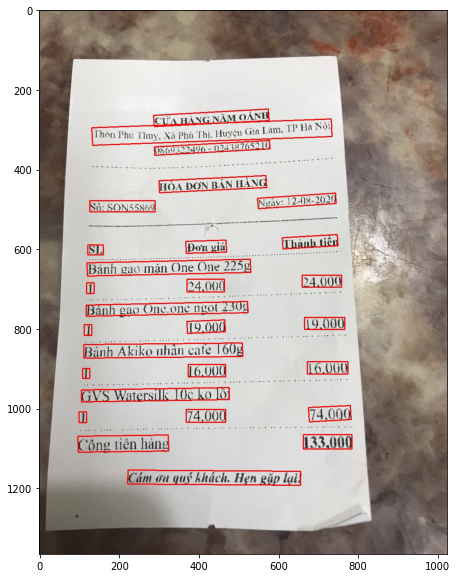

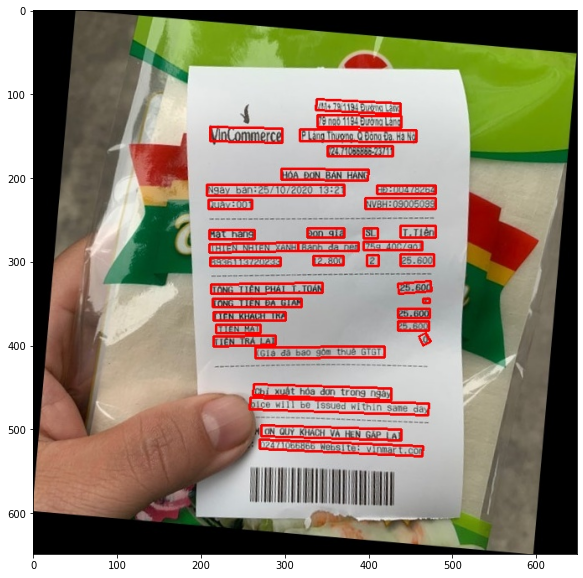

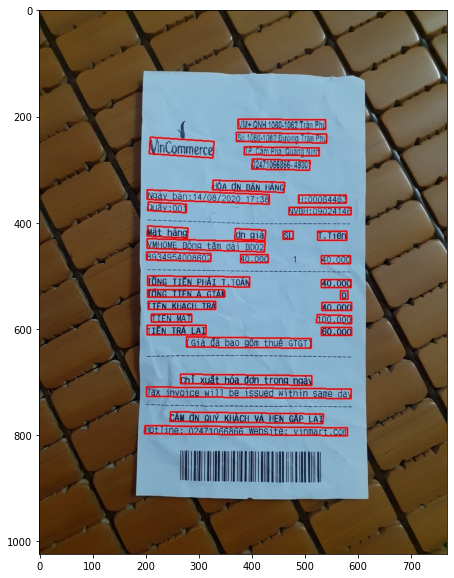

In [ ]:
import glob
 
# get the path/directory
 
# iterate over files in
# that directory
for images in glob.iglob(f'/content/test_output/text_detector/test/viz_imgs/*'):
   
    # check if the image ends with png
    if (images.endswith(".jpg")):
        fig, ax = plt.subplots(1)
        fig.set_size_inches(10, 10)
        print(images)
        image = cv2.imread(images)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        plt.imshow(image)

### ROTATE - CORRECTOR

#### corrector - func

In [ ]:
def get_img_paths(dir_, extensions=('.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG')):
    img_paths = []
    if type(dir_) is list:
        for d in dir_:
            for root, dirs, files in os.walk(d):
                for file in files:
                    for e in extensions:
                        if file.endswith(e):
                            p = os.path.join(root, file)
                            img_paths.append(p)
    else:
        for root, dirs, files in os.walk(dir_):
            for file in files:
                for e in extensions:
                    if file.endswith(e):
                        p = os.path.join(root, file)
                        img_paths.append(p)
    return img_paths


class NewPad(object):
    def __init__(self, t_size=(64, 192), fill=(255, 255, 255), padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        self.t_size = t_size

    def __call__(self, img):
        # def __call__(self, img, t_size):
        target_h, target_w = self.t_size
        # h, w, c = img.shape
        w, h = img.size

        im_scale = h / w
        target_scale = target_h / target_w
        # print(im_scale, target_scale)
        if im_scale < target_scale:
            # keep w, add padding h
            new_w = int(round(target_h / im_scale))
            # new_w =
            out_im = img.resize((new_w, target_h))
            # out_im = img
        else:
            # keep h, add padding w
            new_w = h / target_scale
            _pad = (new_w - w) / 2
            _pad = int(round(_pad))
            padding = (_pad, 0, _pad, 0)  # left, top, right and bottom
            # padding = (0, _pad, 0, _pad)  # left, top, right and bottom
            out_im = pad(img, padding, self.fill, self.padding_mode)
            out_im = out_im.resize((self.t_size[1], self.t_size[0]))
        # print(img.size, out_im.size)
        return out_im

    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'. \
            format(self.fill, self.padding_mode)

In [ ]:
class ClsPostProcess(object):
    """ Convert between text-label and text-index """

    def __init__(self, label_list, **kwargs):
        super(ClsPostProcess, self).__init__()
        self.label_list = label_list

    def __call__(self, preds, label=None, *args, **kwargs):
        if isinstance(preds, torch.Tensor):
            preds = preds.numpy()

        pred_idxs = preds.argmax(axis=1)
        # print('1', preds)
        # print('pred_idxs',pred_idxs)
        decode_out = [(self.label_list[idx], preds[i, idx])
                      for i, idx in enumerate(pred_idxs)]
        if label is None:
            return decode_out
        label = label.argmax(1)
        label = [(self.label_list[idx], 1.0) for idx in label]
        # print(decode_out, label)
        return decode_out, label
class CheckQuality:
    def __init__(self, model=None, transforms=None, weightPath=None, classList=None, backBoneWPath=None, imW=400,
                 imH=252, device=None):
        self.classList = classList
        ## build model
        if device == None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.imW = imW
        self.imH = imH
        self.net_ = model.to(self.device)
        self.net_.load_state_dict(torch.load(weightPath,
                                             map_location=lambda storage, loc: storage))
        self.net_.eval()
        self.transform = transforms
        # net_ = net_.cuda()

    def inference(self, image, debug=False):
        if isinstance(image, str):
            image = Image.open(image)
        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if debug:
                cv2.imshow('box_rectify. Before', image)
                print('Before', image.shape)
                # cv2.waitKey(0)
            image = Image.fromarray(image)

        x = self.transform(image)
        x = x.view(1, 3, self.imH, self.imW)
        x.unsqueeze(0)
        xx = Variable(x).to(self.device)

        out = self.net_(xx)
        preds = nn.Softmax(1)(out)

        post_pr = ClsPostProcess(self.classList)
        post_result = post_pr(preds.clone().detach().numpy())[0]
        image = rotate_image_angle(image, int(post_result[0]))
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if debug:
            cv2.imshow('box_rectify. After', image)
            print('After', image.shape, post_result)
            cv2.waitKey(0)
        return image, post_result

In [ ]:
__all__ = ['MobileNetV3', 'mobilenetv3']


def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU  # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=1000, input_size=224, dropout=0.8, mode='small', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        input_channel = 16
        # last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            last_channel = 2048
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16, 16, False, 'RE', 1],
                [3, 64, 24, False, 'RE', 2],
                [3, 72, 24, False, 'RE', 1],
                [5, 72, 40, True, 'RE', 2],
                [5, 120, 40, True, 'RE', 1],
                [5, 120, 40, True, 'RE', 1],
                [3, 240, 80, False, 'HS', 2],
                [3, 200, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 480, 112, True, 'HS', 1],
                [3, 672, 112, True, 'HS', 1],
                [5, 672, 160, True, 'HS', 2],
                [5, 960, 160, True, 'HS', 1],
                [5, 960, 160, True, 'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            last_channel = 1024
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16, 16, True, 'RE', 2],
                [3, 72, 24, False, 'RE', 2],
                [3, 88, 24, False, 'RE', 1],
                [5, 96, 40, True, 'HS', 2],
                [5, 240, 40, True, 'HS', 1],
                [5, 240, 40, True, 'HS', 1],
                [5, 120, 48, True, 'HS', 1],
                [5, 144, 48, True, 'HS', 1],
                [5, 288, 96, True, 'HS', 2],
                [5, 576, 96, True, 'HS', 1],
                [5, 576, 96, True, 'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),  # refer to paper section 6
            nn.Linear(last_channel, n_class),
            # nn.Softmax(1),
            # nn.Linear(last_channel, 640),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),  # refer to paper section 6
            # nn.Linear(640, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


def mobilenetv3(pretrained=False, n_class=7, input_size=320, dropout=0.2, mode='small', width_mult=1.0):
    model = MobileNetV3(n_class, input_size, dropout, mode, width_mult)
    if pretrained:
        state_dict = torch.load(pretrained)
        model.load_state_dict(state_dict, strict=True)
        # raise NotImplementedError
    return model


def get_model(config):
    pretrained = config.MODEL.PRETRAINED
    n_class = config.DATASET.NUM_CLASSES
    dropout = config.TRAIN.DROPOUT
    input_size = config.TRAIN.IMAGE_SIZE[0]
    mode = 'small'
    width_mult = 1.0
    model = mobilenetv3(pretrained=pretrained, n_class=n_class, dropout=dropout, input_size=input_size)
    return model

In [ ]:
model = mobilenetv3

In [ ]:
def rotate_image_angle(img, angle):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    shape_ = img.shape
    h_org = shape_[0]
    w_org = shape_[1]
    Mat_rotation = cv2.getRotationMatrix2D((w_org / 2, h_org / 2), 360 - angle, 1)
    # print(h_org, w_org)
    rad = math.radians(angle)
    sin = math.sin(rad)
    cos = math.cos(rad)
    bound_w = (h_org * abs(sin)) + (w_org * abs(cos))
    bound_h = (h_org * abs(cos)) + (w_org * abs(sin))
    # print((bound_w / 2) - w_org / 2, ((bound_h / 2) - h_org / 2))
    Mat_rotation[0, 2] += ((bound_w / 2) - w_org / 2) - 1
    Mat_rotation[1, 2] += ((bound_h / 2) - h_org / 2) - 1
    Mat_rotation[1, 2] = 0 if Mat_rotation[1, 2] < 0 else Mat_rotation[1, 2]
    Mat_rotation[0, 2] = 0 if Mat_rotation[0, 2] < 0 else Mat_rotation[0, 2]
    # print(Mat_rotation)
    # Mat_rotation = Mat_rotation.round()
    bound_w, bound_h = int(bound_w), int(bound_h)
    img_result = cv2.warpAffine(img, Mat_rotation, (bound_w, bound_h))
    return img_result
def filter_90_box(boxlist, debug=False, thresh=45):
    if not boxlist:
        return 0
    all_box_angle = []
    for ide, box_data in enumerate(boxlist):
        if isinstance(box_data, dict):
            box = box_data['coors']
        else:
            box = box_data
        pol = poly(box)
        angle_with_horizontal_line = pol.get_horizontal_angle()
        # if 45 < abs(angle_with_horizontal_line) < 135:
        #     continue
        # print(angle_with_horizontal_line)
        # if angle_with_horizontal_line >= 0:
        #     angle_with_horizontal_line = 180 - angle_with_horizontal_line + 90
        # else:
        #     angle_with_horizontal_line = math.fabs(angle_with_horizontal_line) - 90
        all_box_angle.append(angle_with_horizontal_line)
        if debug:
            visual_box(box)

    # if cluster:
    all_box_angle = np.array(all_box_angle)
    all_box_angle_abs = np.absolute(all_box_angle)
    print(all_box_angle_abs.max() - all_box_angle_abs.min())
    if all_box_angle_abs.max() - all_box_angle_abs.min() > thresh:
        codebook, _ = kmeans(all_box_angle_abs, 2)  # three clusters
        cluster_indices, _ = vq(all_box_angle_abs, codebook)
        clas = set(cluster_indices)
        ret = {c: [] for c in clas}
        for idx, v in enumerate(all_box_angle_abs):
            ret[cluster_indices[idx]].append([v, boxlist[idx]])
        ret = list(ret.values())
        ret = sorted(ret, key=lambda e: len(e))
        list_angle_box = ret[-1]

        boxlist = []
        for ide, box_data in enumerate(list_angle_box):
            boxlist.append(box_data[1])
    return boxlist
def get_mean_horizontal_angle(boxlist, debug=False, cluster=True):
    if not boxlist:
        return 0
    all_box_angle = []
    for ide, box_data in enumerate(boxlist):
        if isinstance(box_data, dict):
            box = box_data['coors']
        else:
            box = box_data
        pol = poly(box)
        angle_with_horizontal_line = pol.get_horizontal_angle()
        # if 45 < abs(angle_with_horizontal_line) < 135:
        #     continue
        # print(angle_with_horizontal_line)
        if angle_with_horizontal_line >= 0:
            angle_with_horizontal_line = 180 - angle_with_horizontal_line + 90
        else:
            angle_with_horizontal_line = math.fabs(angle_with_horizontal_line) - 90
        all_box_angle.append(angle_with_horizontal_line)
        if debug:
            visual_box(box)

    if cluster:
        all_box_angle = filter_outliers_angle(all_box_angle)
    # all_box_angle
    mean_angle = np.array(all_box_angle).mean()
    mean_angle = mean_angle - 90
    return mean_angle
def init_box_rectify_model(weight_path):
    classList = ['0', '180']
    device = torch.device('cpu')
    model_ = model(n_class=2, dropout=.2, input_size=64)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform_test = transforms.Compose([
        NewPad(t_size=(64, 192), fill=(255, 255, 255)),
        transforms.Resize((64, 192), interpolation=Image.NEAREST),
        # transforms.CenterCrop((64, 192)),
        # transforms.RandomCrop((arg.input_size[0], arg.input_size[1])),
        transforms.ToTensor(),  # 3*H*W, [0, 1]
        normalize])
    cq = CheckQuality(model=model_, weightPath=weight_path, classList=classList, transforms=transform_test, imW=192,
                      imH=64, device=device)
    return cq
def rotate_image_bbox_angle(img, bboxes, angle):
    def rotate_points(box):
        box_np = np.array(box).astype(np.float)
        box_np = np.rint(box_np).astype(np.int32)
        # print(box_np.shape)
        box_np = box_np.reshape(-1, 2)
        # add ones
        ones = np.ones(shape=(len(box_np), 1))
        points_ones = np.hstack([box_np, ones])
        # transform points
        transformed_points = Mat_rotation.dot(points_ones.T).T
        # print(transformed_points)
        transformed_points2 = transformed_points.reshape(-1)
        transformed_points2 = np.rint(transformed_points2)
        transformed_points2 = transformed_points2.astype(int)
        # print(transformed_points2)
        return transformed_points2

    if not isinstance(img, np.ndarray):
        img = np.array(img)
    shape_ = img.shape
    h_org = shape_[0]
    w_org = shape_[1]
    Mat_rotation = cv2.getRotationMatrix2D((w_org / 2, h_org / 2), 360 - angle, 1)
    # print(h_org, w_org)
    rad = math.radians(angle)
    sin = math.sin(rad)
    cos = math.cos(rad)
    bound_w = (h_org * abs(sin)) + (w_org * abs(cos))
    bound_h = (h_org * abs(cos)) + (w_org * abs(sin))
    # print((bound_w / 2) - w_org / 2, ((bound_h / 2) - h_org / 2))
    Mat_rotation[0, 2] += ((bound_w / 2) - w_org / 2) - 1
    Mat_rotation[1, 2] += ((bound_h / 2) - h_org / 2) - 1
    Mat_rotation[1, 2] = 0 if Mat_rotation[1, 2] < 0 else Mat_rotation[1, 2]
    Mat_rotation[0, 2] = 0 if Mat_rotation[0, 2] < 0 else Mat_rotation[0, 2]
    # print(Mat_rotation)
    # Mat_rotation = Mat_rotation.round()
    bound_w, bound_h = int(bound_w), int(bound_h)
    img_result = cv2.warpAffine(img, Mat_rotation, (bound_w, bound_h))

    ret_boxes = []
    for box_data in bboxes:
        if isinstance(box_data, dict):
            box = box_data['coors']
        else:
            box = box_data
        if isinstance(box, list) and isinstance(box[0], list):
            transformed_points = []
            for b in box:
                transformed_points.append(list(rotate_points(b)))
        else:
            transformed_points = list(rotate_points(box))

        if isinstance(box_data, dict):
            box_data['coors'] = transformed_points
        else:
            box_data = transformed_points
        ret_boxes.append(box_data)

    return img_result, ret_boxes
def rotate_and_crop(img, points, debug=False, rotate=True, extend=True,
                    extend_x_ratio=1, extend_y_ratio=0.01,
                    min_extend_y=1, min_extend_x=2):
    rect = cv2.minAreaRect(points)

    # the order of the box points: bottom left, top left, top right,
    # bottom right
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    if debug:
        print("shape of cnt: {}".format(points.shape))
        print("rect: {}".format(rect))
        print("bounding box: {}".format(box))
    # cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

    # get width and height of the detected rectangle
    height = int(rect[1][0])
    width = int(rect[1][1])

    if extend:
        if width > height:
            w, h = width, height
        else:
            h, w = width, height
        ex = min_extend_x if (extend_x_ratio * w) < min_extend_x else (extend_x_ratio * w)
        ey = min_extend_y if (extend_y_ratio * h) < min_extend_y else (extend_y_ratio * h)
        ex = int(round(ex))
        ey = int(round(ey))
        if width < height:
            ex, ey = ey, ex
    else:
        ex, ey = 0, 0
    src_pts = box.astype("float32")
    # width = width + 10
    # height = height + 10
    dst_pts = np.array([
        [width - 1 + ex, height - 1 + ey],
        [ex, height - 1 + ey],
        [ex, ey],
        [width - 1 + ex, ey]
    ], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    # print(M)
    warped = cv2.warpPerspective(img, M, (width + 2 * ex, height + 2 * ey))
    h, w, c = warped.shape
    rotate_warped = warped
    if w < h and rotate:
        rotate_warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    if debug:
        print('ex, ey', ex, ey)
        cv2.imshow('before rotated', warped)
        cv2.imshow('rotated', rotate_warped)
        cv2.waitKey(0)
    return rotate_warped

def drop_box(boxlist, drop_gap=(.5, 2), debug=False):
    new_boxlist = []
    for ide, box_data in enumerate(boxlist):
        if isinstance(box_data, dict):
            box = box_data['coors']
        else:
            box = box_data
        box_np = np.array(box).astype(np.int32).reshape(-1, 1, 2)
        rect = cv2.minAreaRect(box_np)
        w, h = rect[1]
        if debug:
            visual_box(box)
        if min(drop_gap) < w / h < max(drop_gap):
            continue
        new_boxlist.append(box_data)
    return new_boxlist

#### Main

In [ ]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import yaml

In [ ]:
cls_config_path = '/content/vietocr/config/vgg-seq2seq.yml'
cls_base_config_path = '/content/vietocr/config/base.yml'

In [ ]:
def load_config(base_config_path, config_path):
    with open(base_config_path, encoding='utf-8') as f:
        base_config = yaml.safe_load(f)
    with open(config_path, encoding='utf-8') as f:
        config = yaml.safe_load(f)
    base_config.update(config)
    return Cfg(base_config)
class Classifier_Vietocr:
    def __init__(self, ckpt_path=None, gpu='0'):
        print('Classifier_Vietocr. Init')
        self.config = load_config(cls_base_config_path, cls_config_path)

        if ckpt_path is not None:
            self.config['weights'] = ckpt_path
        self.config['cnn']['pretrained'] = False
        if gpu is not None:
            self.config['device'] = 'cuda:' + str(gpu)
        else:
            self.config['device'] = 'cpu'
        self.config['predictor']['beamsearch'] = False
        self.model = Predictor(self.config)

    def inference(self, numpy_list, debug=False):
        print('Classifier_Vietocr. Inference',len(numpy_list),'boxes')
        text_values = []
        prob_value = []
        for idx, f in enumerate(numpy_list):
            img = Image.fromarray(f)
            s, prob= self.model.predict(img, True)
            if debug:
                print( round(prob,3), s)
                cv2.imshow('sample',f)
                cv2.waitKey(0)
            text_values.append(s)
            prob_value.append(prob)
        return text_values, prob_value

In [ ]:
img_dir = raw_img_dir
img_path=''
ocr_thres = 0.65

In [ ]:
gpu = '0'

#img_dir = raw_img_dir
anno_dir = det_out_txt_dir

output_txt_dir = rot_out_txt_dir
output_viz_dir = rot_out_viz_dir
output_rotated_img_dir = rot_out_img_dir

# vietocr = True
# get bbox
crop_method = 2  # overall method 2 is better than method 1 FOR CLASSIFY
classifier_batch_sz = 4
worker = 1
write_rotated_img = True
write_file = True
visualize = rot_visualize
# extend_bbox = True  # extend bbox when crop or not
debug = False

In [ ]:
def get_list_boxes_from_icdar(anno_path):
    with open(anno_path, 'r', encoding='utf-8') as f:
        anno_txt = f.readlines()
    list_boxes = []
    for anno in anno_txt:
        anno = anno.rstrip('\n')

        idx = -1
        for i in range(0, 8):
            idx = anno.find(',', idx + 1)

        coordinates = anno[:idx]
        coors = [int(f) for f in coordinates.split(',')]
        list_boxes.append({'coors': coors, 'data': anno[idx:]})
    return list_boxes

In [ ]:
def init_models(gpu='0'):
    if gpu != None:
        print('Use GPU', gpu)
        os.environ['CUDA_VISIBLE_DEVICES'] = gpu
    else:
        print('Use CPU')

    classifier = Classifier_Vietocr()

    return classifier

def get_boxes_data1(img_data, boxes, extend_box=True,
                   extend_y_ratio=0.05,
                   min_extend_y=1,
                   extend_x_ratio=0.05,
                   min_extend_x=2):
    boxes_data = []
    for box_loc in boxes:
        box_loc = np.array(box_loc).astype(np.int32).reshape(-1, 1, 2)
        box_data = rotate_and_crop(img_data, box_loc, debug=False, extend=extend_box,
                                   extend_x_ratio=extend_x_ratio, extend_y_ratio=extend_y_ratio,
                                   min_extend_y=min_extend_y, min_extend_x=min_extend_x)
        boxes_data.append(box_data)
    return boxes_data
# def process_mc_ocr_data():
#     begin_init = time.time()
#     global anno_path
#     if not os.path.exists(output_txt_dir):
#         os.makedirs(output_txt_dir)
#     if not os.path.exists(output_viz_dir):
#         os.makedirs(output_viz_dir)
#     if not os.path.exists(output_rotated_img_dir):
#         os.makedirs(output_rotated_img_dir)
#     classifier = init_models(gpu=gpu)
#     end_init = time.time()
#     print('Init models time:', end_init - begin_init, 'seconds')
#     begin = time.time()
#     list_img_path = []
#     if img_path != '':
#         list_img_path.append(img_path)
#     else:
#         list_img_path = get_list_file_in_folder(img_dir)
#     list_img_path = sorted(list_img_path)
#     for idx, img_name in enumerate(list_img_path):
#         if idx < 0:
#             continue
#         # if img_name !='mcocr_private_145120eghoa.jpg':
#         #     continue
#         print('\n', idx, 'Inference', img_name)

#         test_img = cv2.imread(os.path.join(img_dir, img_name))
#         begin_detector = time.time()
#         if img_path == '':
#             anno_path = os.path.join(anno_dir, img_name.replace('.jpg', '.txt'))
#         boxes_list = get_list_boxes_from_icdar(anno_path)

#         end_detector = time.time()
#         print('get boxes from icdar time:', end_detector - begin_detector, 'seconds')

#         list_values = []
#         list_probs = []

#         # 1 Extend x, no extend y

#         boxes_list = drop_box(boxes_list)
#         rotation = get_mean_horizontal_angle(boxes_list, False)
#         img_rotated, boxes_list = rotate_image_bbox_angle(test_img, boxes_list, rotation)

#         total_boxes = len(boxes_list)
#         boxes_data = get_boxes_data1(img_rotated, boxes_list, extend_box=True, min_extend_y=0, extend_y_ratio=0)
#         values, probs = classifier.inference(boxes_data, debug=False)
#         list_values.append(values)
#         list_probs.append(probs)
#         # combine final values and probs
#         final_values = []
#         final_probs = []
#         for idx in range(total_boxes):
#             max_prob = list_probs[0][idx]
#             max_value = list_values[0][idx]
#             for n in range(1, len(list_values)):
#                 if list_probs[n][idx] > max_prob:
#                     max_prob = list_probs[n][idx]
#                     max_value = list_values[n][idx]
#             final_values.append(max_value)
#             final_probs.append(max_prob)
#         print('mean prob:', np.asarray(probs).mean())
#         if np.asarray(probs).mean() < .7: continue
#         end_classifier = time.time()
#         print('Multiscale OCR time:', end_classifier - end_classifier, 'seconds')
#         print('Total predict time:', end_classifier - begin_detector, 'seconds')
#         output_txt_path = os.path.join(output_txt_dir, os.path.basename(img_name).split('.')[0] + '.txt')
#         output_viz_path = os.path.join(output_viz_dir, os.path.basename(img_name))
#         output_rotated_img_path = os.path.join(output_rotated_img_dir, os.path.basename(img_name))
#         if write_rotated_img:
#             cv2.imwrite(output_rotated_img_path, img_rotated)
#         if write_file:
#             write_output(boxes_list, final_values, final_probs, output_txt_path, prob_thres=ocr_thres)
#             # write_output(boxes_list, output_txt_path)

#         if visualize:
#             viz_icdar(img_rotated, output_txt_path, output_viz_path, ignor_type=[])
#             # viz_icdar(os.path.join(img_dir, img_name), output_txt_path, output_viz_path, ignor_type=[])
#             end_visualize = time.time()
#             print('Visualize time:', end_visualize - end_classifier, 'seconds')

#     end = time.time()
#     speed = (end - begin) / len(list_img_path)
#     print('Processing time:', end - begin, 'seconds. Speed:', round(speed, 4), 'second/image')

In [ ]:
os.environ["PYTHONIOENCODING"] = "utf-8"
pred_time = datetime.today().strftime('%Y-%m-%d_%H-%M')



# box rotation classifier
weight_path = rot_model_path
classList = ['0', '180']

print(weight_path)

if gpu is None or debug:
    classifier_batch_sz = 1
    worker = 0


def write_output(list_boxes, result_file_path):
    result = ''
    for idx, box_data in enumerate(list_boxes):
        if isinstance(box_data, dict):
            box = box_data['coors']
            s = [str(i) for i in box]
            line = ','.join(s) + box_data['data']
        else:
            box = box_data
            s = [str(i) for i in box]
            line = ','.join(s) + ','
        result += line + '\n'
    result = result.rstrip('\n')
    with open(result_file_path, 'w', encoding='utf8') as res:
        res.write(result)


def get_boxes_data(img_data, boxes):
    boxes_data = []
    for box_data in boxes:
        if isinstance(box_data, dict):
            box_loc = box_data['coors']
        else:
            box_loc = box_data
        box_loc = np.array(box_loc).astype(np.int32).reshape(-1, 1, 2)
        box_data = rotate_and_crop(img_data, box_loc, debug=False, extend=True,
                                   extend_x_ratio=0.0001,
                                   extend_y_ratio=0.0001,
                                   min_extend_y=2, min_extend_x=1)

        boxes_data.append(box_data)
    return boxes_data


def calculate_page_orient(box_rectify, img_rotated, boxes_list):
    boxes_data = get_boxes_data(img_rotated, boxes_list)
    rotation_state = {'0': 0, '180': 0}
    for it, img in enumerate(boxes_data):
        _, degr = box_rectify.inference(img, debug=False)
        rotation_state[degr[0]] += 1
    print(rotation_state)
    if rotation_state['0'] >= rotation_state['180']:
        ret = 0
    else:
        ret = 180
    return ret


def main():
    begin_init = time.time()
    global anno_path

    if not os.path.exists(output_txt_dir):
        os.makedirs(output_txt_dir)
    if not os.path.exists(output_viz_dir):
        os.makedirs(output_viz_dir)
    if not os.path.exists(output_rotated_img_dir):
        os.makedirs(output_rotated_img_dir)

    box_rectify = init_box_rectify_model(weight_path)
    end_init = time.time()
    print('Init models time:', end_init - begin_init, 'seconds')
    begin = time.time()

    list_img_path = get_list_file_in_folder(img_dir)
    list_img_path = sorted(list_img_path)
    for idx, img_name in enumerate(list_img_path):
        print('\n',idx,'Inference', img_name)
        test_img = cv2.imread(os.path.join(img_dir, img_name))
        begin_detector = time.time()
        anno_path = os.path.join(anno_dir, img_name.replace('.jpg', '.txt'))
        print(anno_path)
        boxes_list = get_list_boxes_from_icdar(anno_path)
        print(boxes_list)
        boxes_list = drop_box(boxes_list, drop_gap=rot_drop_thresh)
        rotation = get_mean_horizontal_angle(boxes_list, False)
        img_rotated, boxes_list = rotate_image_bbox_angle(test_img, boxes_list, rotation)

        # degre = calculate_page_orient(box_rectify, img_rotated, boxes_list)
        # img_rotated, boxes_list = rotate_image_bbox_angle(img_rotated, boxes_list, degre)
        boxes_list = filter_90_box(boxes_list)
        end_detector = time.time()
        print('get boxes from icdar time:', end_detector - begin_detector, 'seconds')

        output_txt_path = os.path.join(output_txt_dir, os.path.basename(img_name).split('.')[0] + '.txt')
        output_viz_path = os.path.join(output_viz_dir, os.path.basename(img_name))
        output_rotated_img_path = os.path.join(output_rotated_img_dir, os.path.basename(img_name))
        if write_rotated_img:
            cv2.imwrite(output_rotated_img_path, img_rotated)
        if write_file:
            print("Write------------------------------------------")
            write_output(boxes_list, output_txt_path)
        if visualize:
            viz_icdar(img_rotated, output_txt_path, output_viz_path)
            end_visualize = time.time()
            print('Visualize time:', end_visualize - end_detector, 'seconds')

    end = time.time()
    speed = (end - begin) / len(list_img_path)
    print('Processing time:', end - begin, 'seconds. Speed:', round(speed, 4), 'second/image')
    print('Done')

/content/rotation_corrector/weights/mobilenetv3-Epoch-487-Loss-0.03-Acc-0.99.pth


### result

Init models time: 0.07236599922180176 seconds

 0 Inference 1.jpg
/content/test_output/text_detector/test/txt/1.txt
[{'coors': [270, 512, 465, 520, 464, 532, 270, 523], 'data': ','}, {'coors': [272, 495, 439, 500, 439, 513, 272, 508], 'data': ','}, {'coors': [259, 462, 472, 469, 471, 483, 258, 476], 'data': ','}, {'coors': [263, 446, 427, 451, 427, 465, 262, 459], 'data': ','}, {'coors': [265, 402, 419, 401, 419, 414, 265, 415], 'data': ','}, {'coors': [215, 389, 289, 388, 289, 399, 215, 401], 'data': ','}, {'coors': [460, 389, 468, 385, 474, 395, 465, 400], 'data': ','}, {'coors': [218, 375, 271, 375, 271, 385, 218, 385], 'data': ','}, {'coors': [435, 371, 472, 371, 472, 382, 435, 382], 'data': ','}, {'coors': [215, 360, 301, 360, 301, 370, 215, 370], 'data': ','}, {'coors': [435, 356, 473, 356, 473, 367, 435, 367], 'data': ','}, {'coors': [214, 344, 320, 344, 320, 354, 214, 354], 'data': ','}, {'coors': [465, 344, 473, 344, 473, 349, 465, 349], 'data': ','}, {'coors': [212, 327, 345,

<ipython-input-211-28c4ddf3815a>:110: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  box_np = np.array(box).astype(np.float)


Visualize time: 0.5488662719726562 seconds

 1 Inference mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.jpg
/content/test_output/text_detector/test/txt/mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.txt
[{'coors': [223, 1154, 656, 1157, 656, 1192, 222, 1189], 'data': ','}, {'coors': [97, 1069, 324, 1066, 325, 1106, 98, 1109], 'data': ','}, {'coors': [663, 1065, 785, 1065, 785, 1101, 663, 1101], 'data': ','}, {'coors': [100, 1008, 119, 1008, 119, 1035, 100, 1035], 'data': ','}, {'coors': [369, 1002, 468, 1002, 468, 1034, 369, 1034], 'data': ','}, {'coors': [676, 997, 781, 992, 783, 1027, 678, 1033], 'data': ','}, {'coors': [106, 953, 477, 947, 477, 977, 106, 983], 'data': ','}, {'coors': [109, 899, 127, 899, 127, 924, 109, 924], 'data': ','}, {'coors': [374, 889, 468, 889, 468, 920, 374, 920], 'data': ','}, {'coors': [673, 882, 775, 882, 775, 913, 673, 913], 'data': ','}, {'coors': [112, 839, 510, 835, 511, 869, 112, 873], 'data': ','}, {'coors': [113, 789, 132, 789, 132, 816,

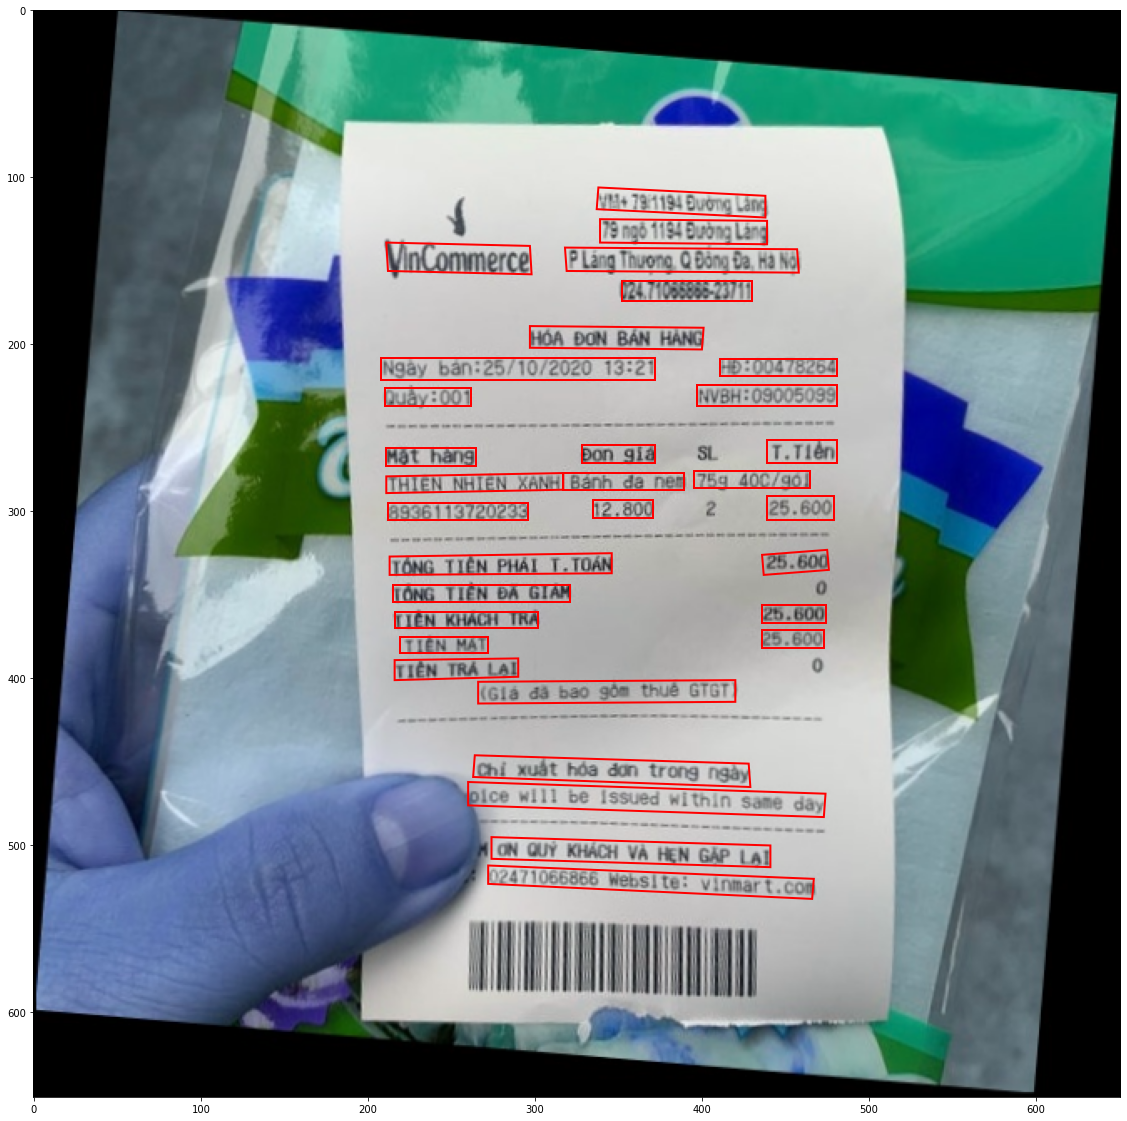

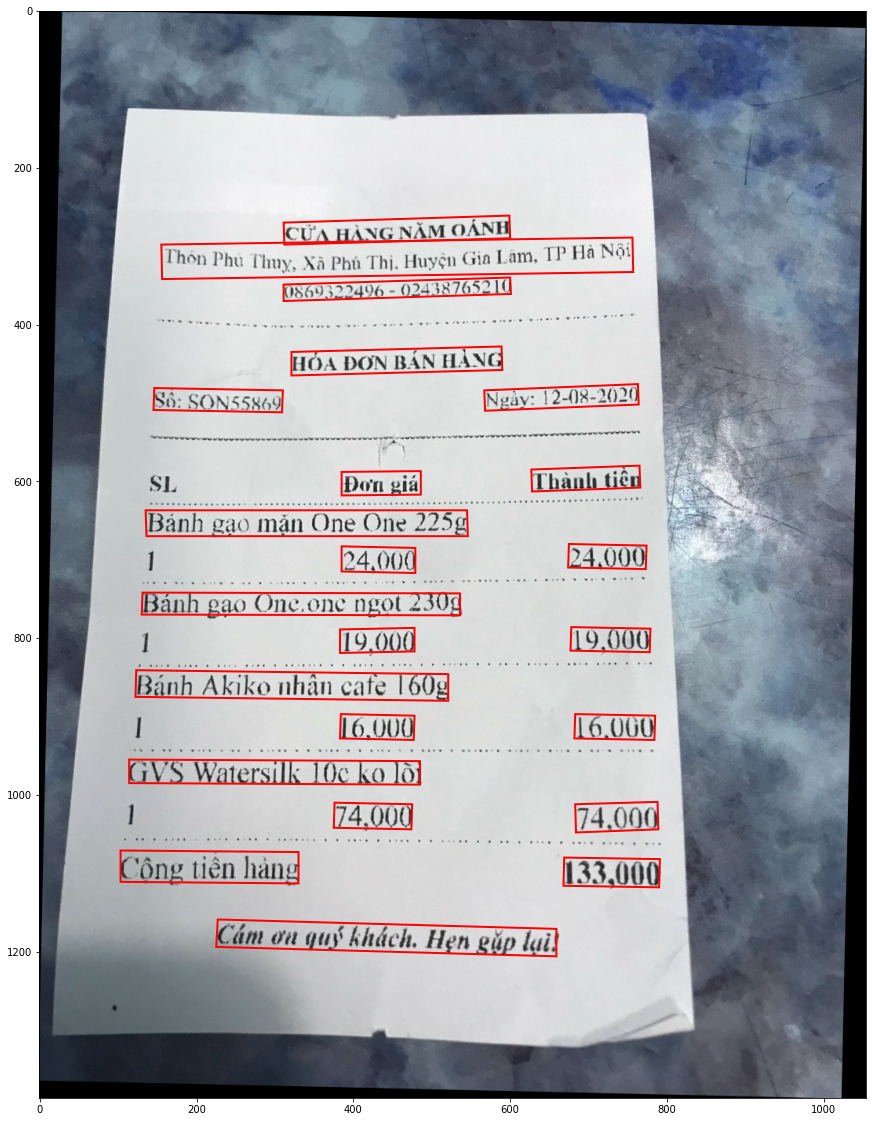

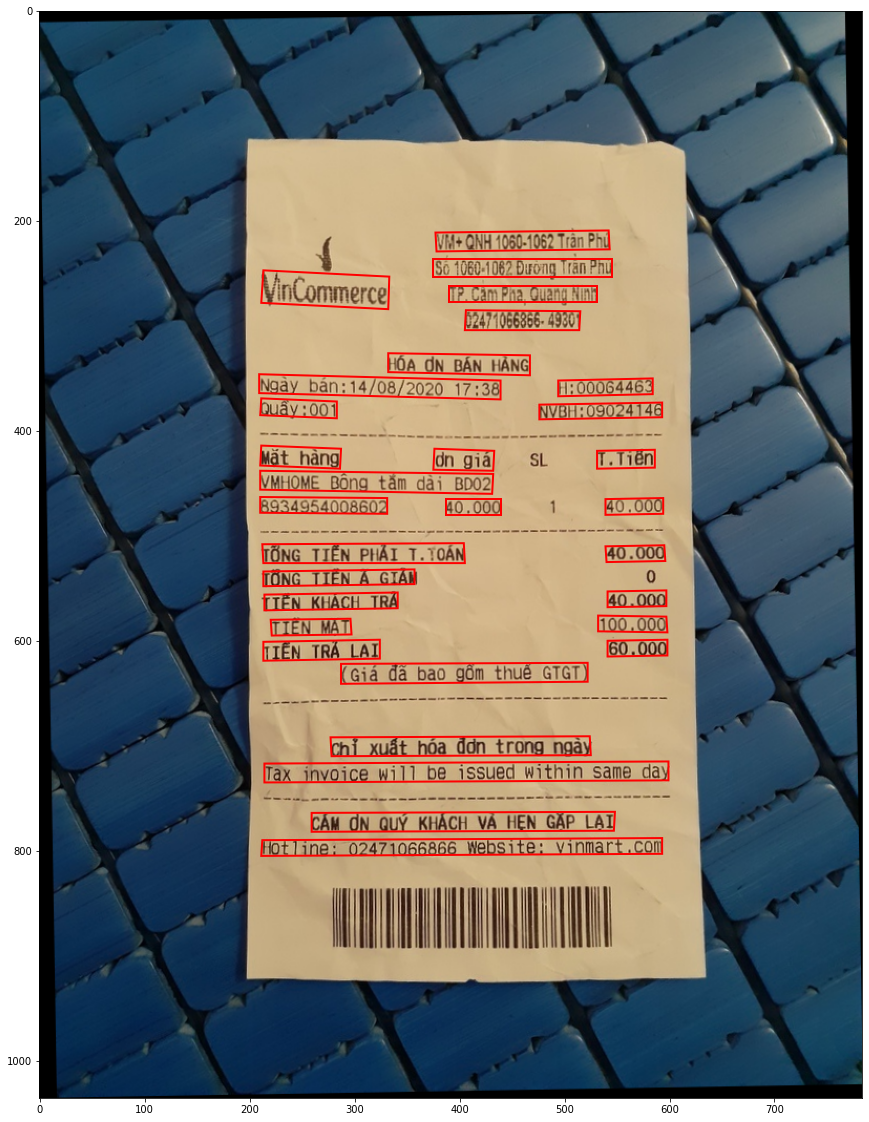

In [ ]:
color_map = {1: 'r', 15: 'green', 16: 'blue', 17: 'm', 18: 'cyan'}
main()


### TEXT - CLASSIFIER

In [ ]:
def get_boxes_data1(img_data, boxes, extend_box=True,
                   extend_y_ratio=0.05,
                   min_extend_y=1,
                   extend_x_ratio=0.05,
                   min_extend_x=2):
    boxes_data = []
    for box_loc in boxes:
        print(box_loc)
        box_loc = np.array(box_loc).astype(np.int32).reshape(-1, 1, 2)
        box_data = rotate_and_crop(img_data, box_loc, debug=False, extend=extend_box,
                                   extend_x_ratio=extend_x_ratio, extend_y_ratio=extend_y_ratio,
                                   min_extend_y=min_extend_y, min_extend_x=min_extend_x)
        boxes_data.append(box_data)
    return boxes_data

def get_list_boxes_from_icdar1(anno_path):
    with open(anno_path, 'r', encoding='utf-8') as f:
        anno_txt = f.readlines()
    list_boxes = []
    for anno in anno_txt:
        anno = anno.rstrip('\n')

        idx = -1
        for i in range(0, 8):
            idx = anno.find(',', idx + 1)

        coordinates = anno[:idx]

        coors = [int(f) for f in coordinates.split(',')]
        list_boxes.append(coors)
    return list_boxes
def write_output1(list_boxes, values, probs, result_file_path, prob_thres=0.7):
    result = ''
    for idx, box in enumerate(list_boxes):
        s = [str(i) for i in box]
        if probs[idx] > prob_thres:
            line = ','.join(s) + ',' + values[idx]
        else:
            line = ','.join(s) + ','
        result += line + '\n'
    result = result.rstrip('\n')
    with open(result_file_path, 'w', encoding='utf8') as res:
        res.write(result)

In [ ]:
color_map = {1: 'r', 15: 'green', 16: 'blue', 17: 'm', 18: 'cyan'}
os.environ["PYTHONIOENCODING"] = "utf-8"
pred_time = datetime.today().strftime('%Y-%m-%d_%H-%M')

img_dir = rot_out_img_dir
img_path = ''
anno_dir =  rot_out_txt_dir # det_out_txt_dir # rot_out_txt_dir
anno_path = ''

write_file = True



begin_init = time.time()
#global anno_path
classifier = init_models(gpu=gpu)
end_init = time.time()
print('Init models time:', end_init - begin_init, 'seconds')
begin = time.time()
list_img_path = []
if img_path != '':
    list_img_path.append(img_path)
else:
    list_img_path = get_list_file_in_folder('/content/test_output/rotation_corrector/test/imgs')
list_img_path = sorted(list_img_path)
for idx, img_name in enumerate(list_img_path):
    if idx < 0:
        continue
    print('\n', idx, 'Inference', img_name)
    test_img = cv2.imread(os.path.join(img_dir, img_name))
    begin_detector = time.time()
    if img_path == '':
        anno_path = os.path.join(anno_dir, img_name.replace('.jpg', '.txt'))
    boxes_list = get_list_boxes_from_icdar1(anno_path)
    end_detector = time.time()
    print('get boxes from icdar time:', end_detector - begin_detector, 'seconds')
    # multiscale ocr
    list_values = []
    list_probs = []
    total_boxes = len(boxes_list)
    # 1 Extend x, no extend y
    boxes_data = get_boxes_data1(test_img, boxes_list, extend_box=True, min_extend_y=0, extend_y_ratio=0)
    values, probs = classifier.inference(boxes_data, debug=False)
    list_values.append(values)
    list_probs.append(probs)
    # 2 extend y by 10%
    boxes_data = get_boxes_data1(test_img, boxes_list, extend_box=True, min_extend_y=2, extend_y_ratio=0.1)
    values, probs = classifier.inference(boxes_data, debug=False)
    list_values.append(values)
    list_probs.append(probs)
    # 3 extend y by 20%
    boxes_data = get_boxes_data1(test_img, boxes_list, extend_box=True, min_extend_y=4, extend_y_ratio=0.2)
    values, probs = classifier.inference(boxes_data, debug=False)
    list_values.append(values)
    list_probs.append(probs)
    # combine final values and probs
    final_values = []
    final_probs = []
    for idx in range(total_boxes):
        max_prob = list_probs[0][idx]
        max_value = list_values[0][idx]
        for n in range(1, len(list_values)):
            if list_probs[n][idx] > max_prob:
                max_prob = list_probs[n][idx]
                max_value = list_values[n][idx]
        final_values.append(max_value)
        final_probs.append(max_prob)
    end_classifier = time.time()
    print('Multiscale OCR time:', end_classifier - end_detector, 'seconds')
    print('Total predict time:', end_classifier - begin_detector, 'seconds')
    output_txt_path = os.path.join(cls_out_txt_dir, os.path.basename(img_name).split('.')[0] + '.txt')
    output_viz_path = os.path.join(cls_out_viz_dir, os.path.basename(img_name))
    if write_file:
        write_output1(boxes_list, final_values, final_probs, output_txt_path, prob_thres=cls_ocr_thres)
    # if cls_visualize:
    #     viz_icdar(os.path.join(img_dir, img_name), output_txt_path, output_viz_path, ignor_type=[])
    #     end_visualize = time.time()
    #     print('Visualize time:', end_visualize - end_classifier, 'seconds')
end = time.time()
speed = (end - begin) / len(list_img_path)
print('\nTotal processing time:', end - begin, 'seconds. Speed:', round(speed, 4), 'second/image')

Use GPU 0
Classifier_Vietocr. Init
Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!
Init models time: 2.545814275741577 seconds

 0 Inference 1.jpg
get boxes from icdar time: 0.0003414154052734375 seconds
[272, 512, 467, 520, 466, 532, 272, 523]
[274, 495, 441, 500, 441, 513, 274, 508]
[260, 462, 474, 469, 473, 483, 260, 476]
[264, 446, 428, 451, 429, 465, 263, 459]
[266, 402, 420, 401, 420, 414, 266, 415]
[216, 389, 290, 388, 290, 399, 216, 401]
[219, 375, 272, 375, 272, 385, 219, 385]
[436, 371, 473, 371, 473, 382, 436, 382]
[216, 360, 302, 360, 302, 370, 216, 370]
[436, 356, 474, 356, 474, 367, 436, 367]
[215, 344, 321, 344, 321, 354, 215, 354]
[213, 327, 346, 325, 346, 337, 213, 338]
[436, 326, 475, 323, 476, 335, 437, 338]
[212, 295, 296, 295, 296, 305, 212, 305]
[335, 293, 371, 293, 371, 304, 335, 304]
[439, 291, 479, 291, 479, 305, 439, 305]
[317, 277, 389, 277, 389, 287, 317, 287]
[211, 279, 317, 277, 317, 287, 211, 289]
[395, 276, 465, 276, 465, 286, 395, 286]
[211, 

### PICK MODEL

In [ ]:
import csv, json, random

In [ ]:
def get_list_icdar_poly(icdar_path, ignore_kie_type = False):
    '''

    :param icdar_path: path of icdar txt file
    :return:
    '''
    list_icdar_poly = []

    with open(icdar_path, 'r', encoding='utf-8') as f:
        anno_txt = f.readlines()

    for anno in anno_txt:
        anno = anno.rstrip('\n')

        idx = -1
        for i in range(0, 8):
            idx = anno.find(',', idx + 1)

        coordinates = anno[:idx]
        val = anno[idx + 1:]
        type=1
        if ignore_kie_type:
            last_comma_idx = val.rfind(',')
            type_str = val[last_comma_idx + 1:]
            val = val[:last_comma_idx]
            if type_str in inv_type_map.keys():
                type = inv_type_map[type_str]

        coors = [int(f) for f in coordinates.split(',')]
        pol = poly(coors, type=type, value=val)
        list_icdar_poly.append(pol)
    return list_icdar_poly
def cer_loss_one_image(sim_pred, label):
    if (max(len(sim_pred), len(label)) > 0):
        loss = Levenshtein.distance(sim_pred, label) * 1.0 / max(len(sim_pred), len(label))
    else:
        return 0
    return loss
def get_list_gt_poly(row, add_key_to_value=False):
    '''

    :param row: get from csv file
    :return:
    '''
    list_gt_poly = []
    boxes = ast.literal_eval(row[1])
    key, value = row[3].split('|||'), row[2].split('|||')
    num_box, score = row[4], row[5]
    if int(num_box) <= 0:
        return list_gt_poly

    print('Num_box:', num_box, 'Score:', score)
    for idx, k in enumerate(key):
        print(idx, boxes[idx]['category_id'], k, ':', value[idx], boxes[idx]['segmentation'])
    index = {15: 0, 16: 0, 17: 0, 18: 0}

    for idx, box in enumerate(boxes):
        # print(box['segmentation'])
        coors = box['segmentation']
        total_box = 0
        for coor in coors:
            if len(coor) < 8:
                continue
            else:
                final_value = value[idx]
                if add_key_to_value and box['category_id'] in index.keys():
                    final_value += ','+type_map[box['category_id']] + '_' + str(index[box['category_id']])
                pol = poly(coor, type=box['category_id'], value=final_value)
                list_gt_poly.append(pol)
                total_box += 1
        if add_key_to_value and box['category_id'] in index.keys():
            index[box['category_id']] += 1
        # print('total box', total_box)
    return list_gt_poly

def find_TOTALCOST_val_poly(keys_poly, list_poly, expand_ratio=0.2):
    total_x, total_y = 0, 0
    min_h, max_h = 5000, 0
    value=None
    for pts in keys_poly.list_pts:
        total_x += pts[0]
        total_y += pts[1]
        if pts[1] < min_h:
            min_h = pts[1]
        if pts[1] > max_h:
            max_h = pts[1]
    expand_value = (max_h - min_h) * expand_ratio
    min_h = min_h - expand_value
    max_h = max_h + expand_value
    center_key_pts = (total_x / 4, total_y / 4)

    min_distance = 10000
    min_idx = None
    for idx, poly in enumerate(list_poly):
        total_x, total_y = 0, 0
        for pts in poly.list_pts:
            total_x += pts[0]
            total_y += pts[1]
        center_can_pts = (total_x / 4, total_y / 4)
        if center_can_pts[1] > min_h and center_can_pts[1] < max_h and center_can_pts[0] > center_key_pts[0]:
            dis = euclidean_distance(center_key_pts, center_can_pts)
            if dis < min_distance:
                min_distance = dis
                min_idx = idx
    if min_idx is not None:
        list_poly[min_idx].type = 18
        value = list_poly[min_idx].value
    return value

In [ ]:
color_map = {15: (0, 255, 0), 16: (255, 0, 0), 17: (0, 0, 255), 18: (0, 255, 255)}

In [ ]:
TOTAL_COST_chars = '0123456789-,.đdvn '
TOTAL_COST_keys = ['TỔNG TIỀN PHẢI T.TOÁN', 'Cộng tiền hàng', 'Tổng cộng', 'Tong cong', 'Tổng cộng (đã gồm VAT)',
                   'Tổng tiền', 'Tổng tiền hàng', 'TỔNG CỘNG', 'Tổng số tiền thanh toán', 'Tiền Thanh Toán',
                   'Thành Tiền', 'Total Amount', 'Total', 'Tổng thanh toán', 'Tại quầy', 'Tổng số thanh toán', 'Tổng hóa đơn (VNĐ)']

TIMESTAMP_keys = ['Ngày', 'Thời gian']
TIMESTAMP_noise_keys = ['Số HĐ', 'Số GD']


def validate_TOTAL_COST_amount(input_str, thres=0.8):
    if len(input_str) == 0:
        return False
    count = 0
    input_str = input_str.lower()
    for ch in input_str:
        if ch in TOTAL_COST_chars:
            count += 1
    score = count / len(input_str)
    #print(score)
    return True if score > thres else False


def validate_TOTAL_COST_keys(input_str, cer_thres=0.2):
    lower_totalcost = input_str.lower()
    min_cer = 1
    for k in TOTAL_COST_keys:
        lower_k = k.lower()
        cer = cer_loss_one_image(lower_totalcost, lower_k)
        if cer < min_cer:
            min_cer = cer
    return True if min_cer < cer_thres else False


def validate_TIMESTAMP(input_str):
    lower_totalcost = input_str.lower()
    for k in TIMESTAMP_keys:
        lower_k = k.lower() +':'
        if lower_k in lower_totalcost:
            print(k, input_str)
            return True
    return False

def validate_SELLER(list_seller, input_str, cer_thres=0.2):
    if len(input_str) < 10:
        return False
    input_str = input_str.lower()
    min_cer = 1
    min_str = ''
    for s in list_seller:
        if s['count'] > 1:
            for line in s['SELLER']:
                lower_line = line.lower()
                cer = cer_loss_one_image(lower_line, input_str)
                if cer < min_cer:
                    min_cer = cer
                    min_str = lower_line
    if min_cer < cer_thres:
        print(round(min_cer, 2), input_str, '-----', min_str)
    return True if min_cer < cer_thres else False


def validate_ADDRESS(list_address, input_str, cer_thres=0.2):
    if len(input_str) < 10:
        return False
    input_str = input_str.lower()
    min_cer = 1
    min_str = ''
    for s in list_address:
        if s['count'] > 1:
            for line in s['ADDRESS']:
                lower_line = line.lower()
                cer = cer_loss_one_image(lower_line, input_str)
                if cer < min_cer:
                    min_cer = cer
                    min_str = lower_line
    if min_cer < cer_thres:
        print(round(min_cer, 2), input_str, '-----', min_str)
    return True if min_cer < cer_thres else False


def fix_datetime(input_str):  # for string len >42
    input_str = input_str.lstrip(' ').rstrip(' ')
    lower_input_str = input_str.lower()
    final_time_pos = -1
    for k in TIMESTAMP_keys:
        lower_k = k.lower()
        time_pos = lower_input_str.find(lower_k)
        if time_pos != -1:
            final_time_pos = time_pos

    final_noise_pos = -1
    for k in TIMESTAMP_noise_keys:
        lower_k = k.lower()
        noise_pos = lower_input_str.find(lower_k)
        if noise_pos != -1:
            final_noise_pos = noise_pos

    final_str = input_str
    if final_noise_pos > 0:
        final_str = input_str[:final_noise_pos]
    if final_time_pos > 0:
        final_str = input_str[final_time_pos:]

    final_str = final_str.lstrip(' ').rstrip(' ')

    return final_str

    # final_str = result_dict['TIMESTAMP'][0][time_pos:]
    # if ' -' not in final_str:
    #     final_str = final_str.replace('-', ' -')
    # if '- ' not in final_str:
    #     final_str = final_str.replace('-', '- ')
    # result_dict['TIMESTAMP'][0] = final_str



def fix_totalcost(list_totalcost, output_ocr_path = None):
    final_list = []
    if len(list_totalcost) == 2:
        if validate_TOTAL_COST_amount(list_totalcost[0]) or validate_TOTAL_COST_keys(list_totalcost[1]):
            list_totalcost[0], list_totalcost[1] = list_totalcost[1], list_totalcost[0]
        final_list = list_totalcost
    elif len(list_totalcost) >= 3:
        # print('\n', list_totalcost)
        min_cer = 1
        min_str = ''
        for idx, totalcost in enumerate(list_totalcost):
            lower_totalcost = totalcost.lower()
            for k in TOTAL_COST_keys:
                lower_k = k.lower()
                cer = cer_loss_one_image(lower_totalcost, lower_k)
                if cer < min_cer:
                    min_cer = cer
                    min_str = totalcost

        final_list.append(min_str)

        max_len = 0
        max_str = ''
        for idx, totalcost in enumerate(list_totalcost):
            lower_totalcost = totalcost.lower()
            if validate_TOTAL_COST_amount(lower_totalcost):
                if len(totalcost) > max_len:
                    max_len = len(totalcost)
                    max_str = totalcost

        final_list.append(max_str)
        # print(img_name,final_list)
    elif len(list_totalcost)==1:
        #print(os.path.basename(output_ocr_path))
        #print(list_totalcost[0])
        list_icdar_poly = get_list_icdar_poly(output_ocr_path)
        for icdar_pol in list_icdar_poly:
            if icdar_pol.value == list_totalcost[0] and validate_TOTAL_COST_keys(icdar_pol.value, cer_thres=0.2):
                TOTAL_COST_value = find_TOTALCOST_val_poly(keys_poly=icdar_pol,
                                        list_poly=list_icdar_poly, expand_ratio=0.2)
                if TOTAL_COST_value is not None:
                    #print(TOTAL_COST_value)
                    list_totalcost.append(TOTAL_COST_value)
        final_list = list_totalcost
    else:
        final_list = list_totalcost
    return final_list


In [ ]:
import ast

In [ ]:
def parse_anno_from_csv_to_icdar_result(csv_file, icdar_dir, output_dir, img_dir=None, debug=False):
    with open(csv_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        first_line = True

        total_boxes_not_match = 0
        total_boxes = 0
        for n, row in enumerate(csv_reader):
            if first_line:
                first_line = False
                continue
            if n < 0:
                continue
            img_name = row[0]
            print('\n' + str(n), img_name)
            # if 'mcocr_public_145014smasw' not in img_name:
            #     continue
            src_img = cv2.imread(os.path.join(img_dir, img_name))
            # src_img = cv2.imread(os.path.join(img_dir, 'viz_' + img_name))

            # Read all poly from training data
            list_gt_poly = get_list_gt_poly(row)

            # Read all poly from icdar
            icdar_path = os.path.join(icdar_dir, img_name.replace('.jpg', '.txt'))
            list_icdar_poly = get_list_icdar_poly(icdar_path)

            # Compare iou and parse text from training data
            for pol in list_gt_poly:
                total_boxes += 1
                match = False
                if debug:
                    gt_img = src_img.copy()
                    gt_box = np.array(pol.list_pts).astype(np.int32)
                    cv2.polylines(gt_img, [gt_box], True, color=color_map[pol.type], thickness=2)
                max_iou = 0
                for icdar_pol in list_icdar_poly:
                    iou = IoU(pol, icdar_pol, False)
                    if iou > max_iou:
                        max_iou = iou
                    cer = cer_loss_one_image(pol.value, icdar_pol.value)
                    if debug:
                        pred_img = src_img.copy()
                        pred_box = np.array(icdar_pol.list_pts).astype(np.int32)
                        cv2.polylines(pred_img, [pred_box], True, color=color_map[pol.type], thickness=2)
                    if iou > 0.3:
                        match = True
                        print('gt  :', pol.value)
                        print('pred:', icdar_pol.value)
                        print('cer', round(cer, 3), ',iou', iou)
                        icdar_pol.type = pol.type

                if not match:
                    total_boxes_not_match += 1
                    print(' not match gt  :', pol.value)
                    print('Max_iou', max_iou)
                    if debug:
                        gt_img_res = cv2.resize(gt_img, (int(gt_img.shape[1]/2),int(gt_img.shape[0]/2)))
                        cv2.imshow('not match gt box', gt_img_res)
                        cv2.waitKey(0)

            # save to output file
            output_icdar_path = os.path.join(output_dir, img_name.replace('.jpg', '.txt'))
            output_icdar_txt = ''
            for icdar_pol in list_icdar_poly:
                output_icdar_txt += icdar_pol.to_icdar_line(map_type=type_map) + '\n'

            output_icdar_txt = output_icdar_txt.rstrip('\n')
            with open(output_icdar_path, 'w', encoding='utf-8') as f:
                f.write(output_icdar_txt)
            if total_boxes > 0:
                print('Total not match', total_boxes_not_match, 'total boxes', total_boxes, 'not match ratio',
                      round(total_boxes_not_match / total_boxes, 3))





def modify_kie_training_data_by_rules(txt_dir, json_data_path, debug=False):
    list_files = get_list_file_in_folder(txt_dir, ext=['.txt'])

    with open(json_data_path) as json_file:
        data = json.load(json_file)

        list_seller = data['seller']
        list_address = data['address']
    for idx, file in enumerate(list_files):
        # with open(os.path.join(txt_dir, file), mode='r', encoding='utf-8') as f:
        #     anno_list= f.readlines()
        #
        # if 'mcocr_public_145014smasw' not in file:
        #     continue
        # print(idx, file)

        list_icdar_poly = get_list_icdar_poly(os.path.join(txt_dir, file), ignore_kie_type=True)

        modify = False
        has_TOTALCOST_keys = False
        has_TOTALCOST_val = False
        for icdar_pol in list_icdar_poly:
            # fix wrong SELLER
            if icdar_pol.type != 15 and validate_SELLER(list_seller, icdar_pol.value):
                icdar_pol.type = 15
                modify = True

            # fix wrong ADDRESS
            if icdar_pol.type != 16 and validate_ADDRESS(list_address, icdar_pol.value):
                icdar_pol.type = 16
                modify = True

            # fix wrong num ber in ADDRESS or SELLER
            if icdar_pol.type in [15, 16] and validate_TOTAL_COST_amount(icdar_pol.value):
                icdar_pol.type = 1
                modify = True
                # print(idx, file, icdar_pol.value)

            # Fix TIMESTAMP
            if icdar_pol.type != 17 and validate_TIMESTAMP(icdar_pol.value):
                icdar_pol.type = 17
                modify = True

            # Fix TOTALCOST
            # if icdar_pol.type == 18:
            #     kk=1
            if icdar_pol.type == 18 and validate_TOTAL_COST_keys(icdar_pol.value, cer_thres=0.2):
                has_TOTALCOST_keys = True
                for icdar_pol2 in list_icdar_poly:
                    if icdar_pol2.type == 18:
                        if validate_TOTAL_COST_amount(icdar_pol2.value, thres=0.7) or icdar_pol2.value == '':
                            has_TOTALCOST_val = True
                if not has_TOTALCOST_val:
                    modify = True
                    find_TOTALCOST_val_poly(keys_poly=icdar_pol,
                                            list_poly=list_icdar_poly)
                    # img=cv2.imread(os.path.join(img_dir, file.replace('.txt','.jpg')))
                    # cv2.imshow('img', img)
                    # cv2.waitKey(0)

        if modify:
            modify_icdar = ''
            for icdar_pol in list_icdar_poly:
                line = icdar_pol.to_icdar_line(type_map)
                modify_icdar += line + '\n'
            modify_icdar = modify_icdar.rstrip('\n')
            print(idx, file)
            with open(os.path.join(txt_dir, file), mode='w', encoding='utf-8') as f:
                f.write(modify_icdar)


def create_data_pick_boxes_and_transcripts(icdar_dir, output_dir):
    list_file = get_list_file_in_folder(icdar_dir, ext=['txt'])
    for idx, anno in enumerate(list_file):
        print(idx, anno)
        with open(os.path.join(icdar_dir, anno), mode='r', encoding='utf-8') as f:
            list_bboxes = f.readlines()
        for idx, line in enumerate(list_bboxes):
            list_bboxes[idx] = str(idx + 1) + ',' + line
        with open(os.path.join(output_dir, anno.replace('.txt', '.tsv')), mode='wt', encoding='utf-8') as f:
            f.writelines(list_bboxes)


def create_data_pick_csv_train_val(train_dir, train_ratio=0.92):
    list_files = get_list_file_in_folder(os.path.join(train_dir, 'images'))
    num_total = len(list_files)
    num_train = int(num_total * train_ratio)
    num_val = num_total - num_train

    random.shuffle(list_files)
    list_train = list_files[:num_train]
    list_val = list_files[num_train + 1:]

    train_txt_list = []
    for idx, f in enumerate(list_train):
        line = ','.join([str(idx + 1), 'receipts', f])
        train_txt_list.append(line + '\n')

    with open(os.path.join(train_dir, 'train_list.csv'), mode='w', encoding='utf-8') as f:
        f.writelines(train_txt_list)

    val_txt_list = []
    for idx, f in enumerate(list_val):
        line = ','.join([str(idx + 1), 'receipts', f])
        val_txt_list.append(line + '\n')

    with open(os.path.join(train_dir, 'val_list.csv'), mode='w', encoding='utf-8') as f:
        f.writelines(val_txt_list)
    print('Done')

if __name__ == '__main__':

    
    # parse_anno_from_csv_to_icdar_result(csv_file="/content/mcocr_train_df.csv",
    #                                     icdar_dir=cls_out_txt_dir,
    #                                     output_dir=kie_out_txt_dir,
    #                                     img_dir=rot_out_img_dir,
    #                                     debug=False)

    # modify_kie_training_data_by_rules(txt_dir=kie_out_txt_dir,
    #                                   json_data_path=json_data_path)

    # from mc_ocr.utils.visualize import viz_icdar_multi
    # viz_icdar_multi(img_dir=rot_out_img_dir,
    #                 anno_dir= kie_out_txt_dir,
    #                 save_viz_dir=kie_out_viz_dir,
    #                 extract_kie_type=True)

    kie_train_dir = os.path.dirname(kie_out_txt_dir)
    #os.symlink(rot_out_img_dir, os.path.join(kie_train_dir,'images'))

    create_data_pick_boxes_and_transcripts(icdar_dir=cls_out_txt_dir,
                                           output_dir=kie_boxes_transcripts)

    #create_data_pick_csv_train_val(kie_train_dir, train_ratio=0.92)


0 mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.txt
1 mcocr_warmup_4c738c975293886e726d29c13b10aabc_00045.txt
2 1.txt


In [ ]:
%cd PICK

/content/PICK


In [ ]:
!python test.py  --batch_size 1

create_data_pick_boxes_and_transcripts...
Loading checkpoint: /content/PICK/model_best.pth 
with saved mEF 0.9390 ...
0 1.txt , inference time: 0.23748564720153809
1 mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.txt , inference time: 0.19607973098754883
2 mcocr_warmup_4c738c975293886e726d29c13b10aabc_00045.txt , inference time: 0.16972875595092773
time run program 0.8802051544189453


0 1.txt
Save visualized result to /content/test_output/key_info_extraction/test/viz_imgs/1.jpg
1 mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.txt
Save visualized result to /content/test_output/key_info_extraction/test/viz_imgs/mcocr_warmup_0dc387ad0764b593a49372063818fa81_00017.jpg
2 mcocr_warmup_4c738c975293886e726d29c13b10aabc_00045.txt
Save visualized result to /content/test_output/key_info_extraction/test/viz_imgs/mcocr_warmup_4c738c975293886e726d29c13b10aabc_00045.jpg


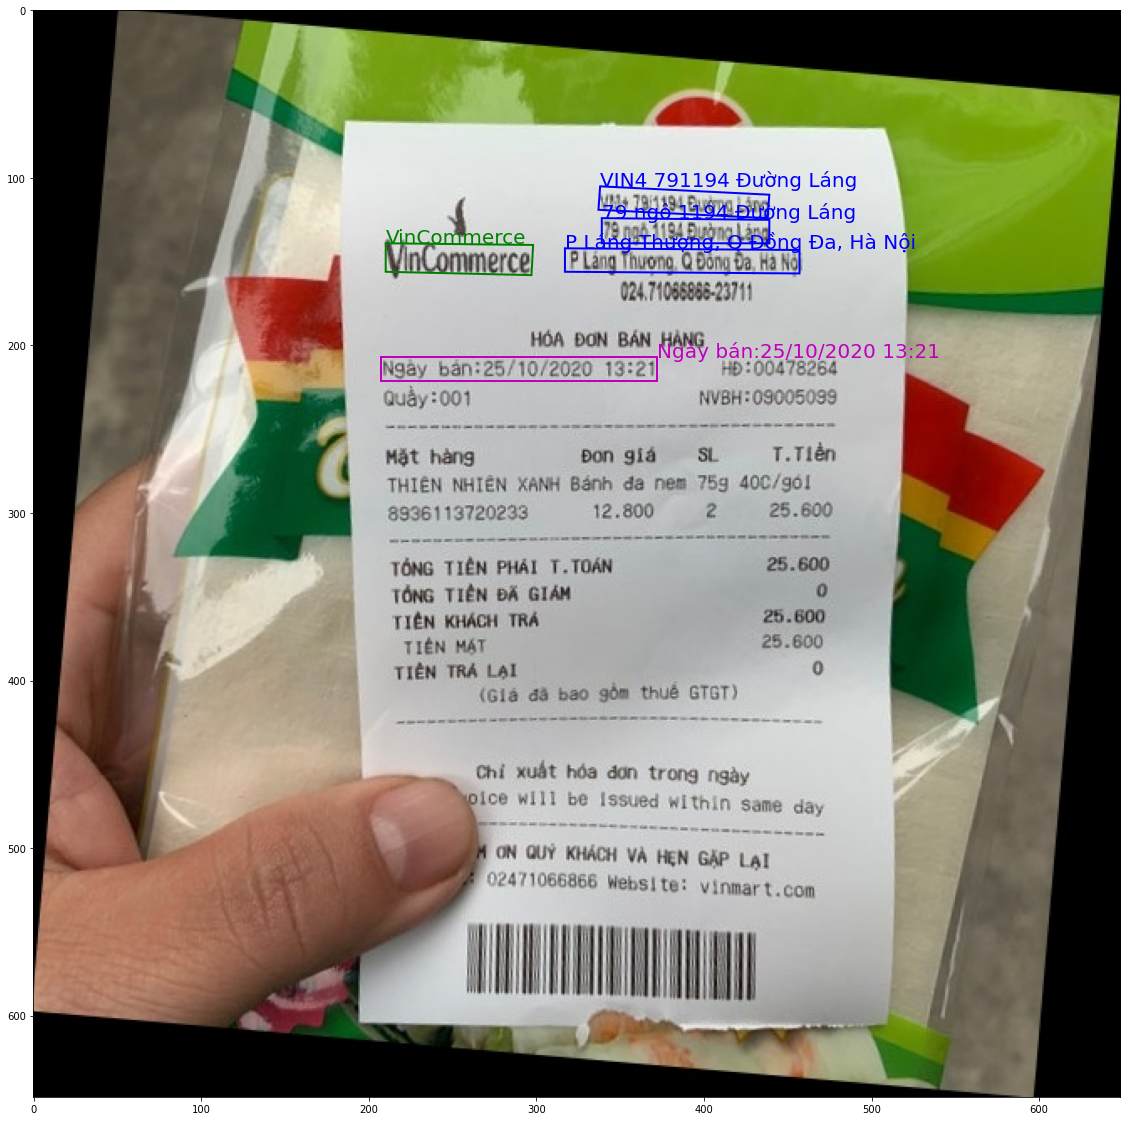

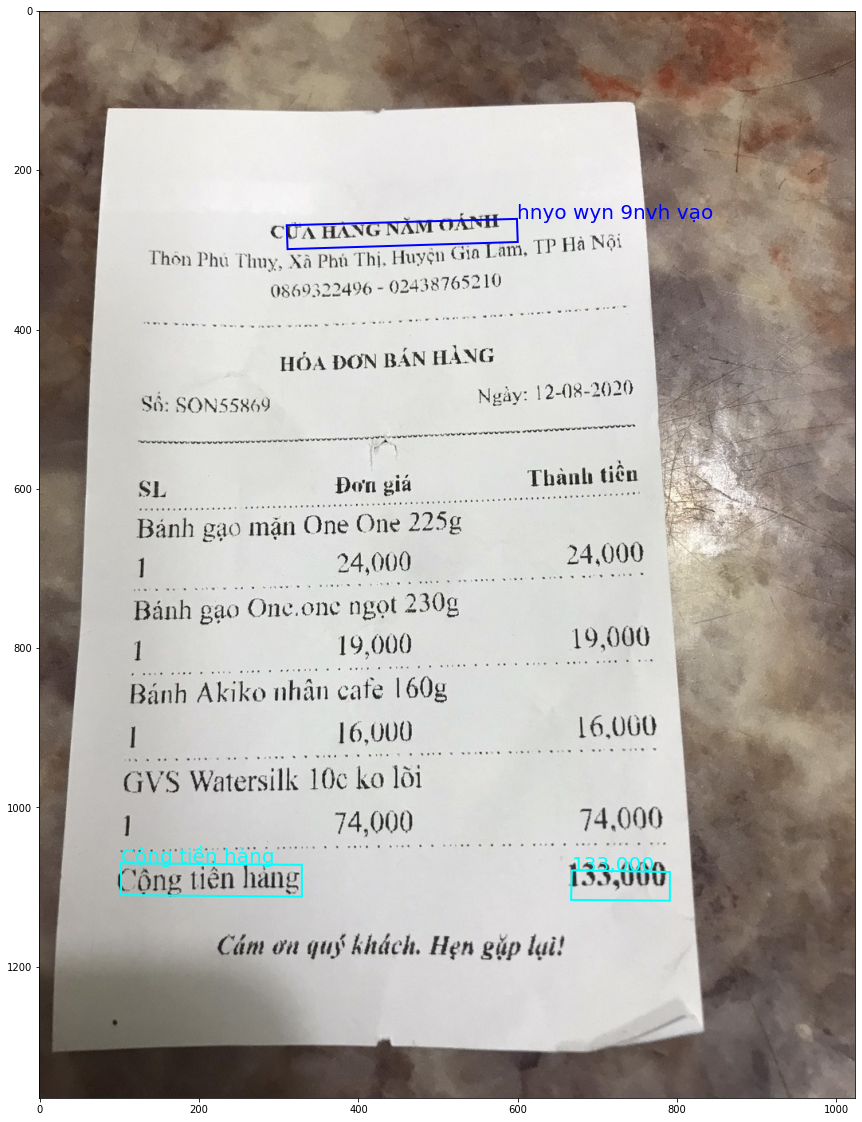

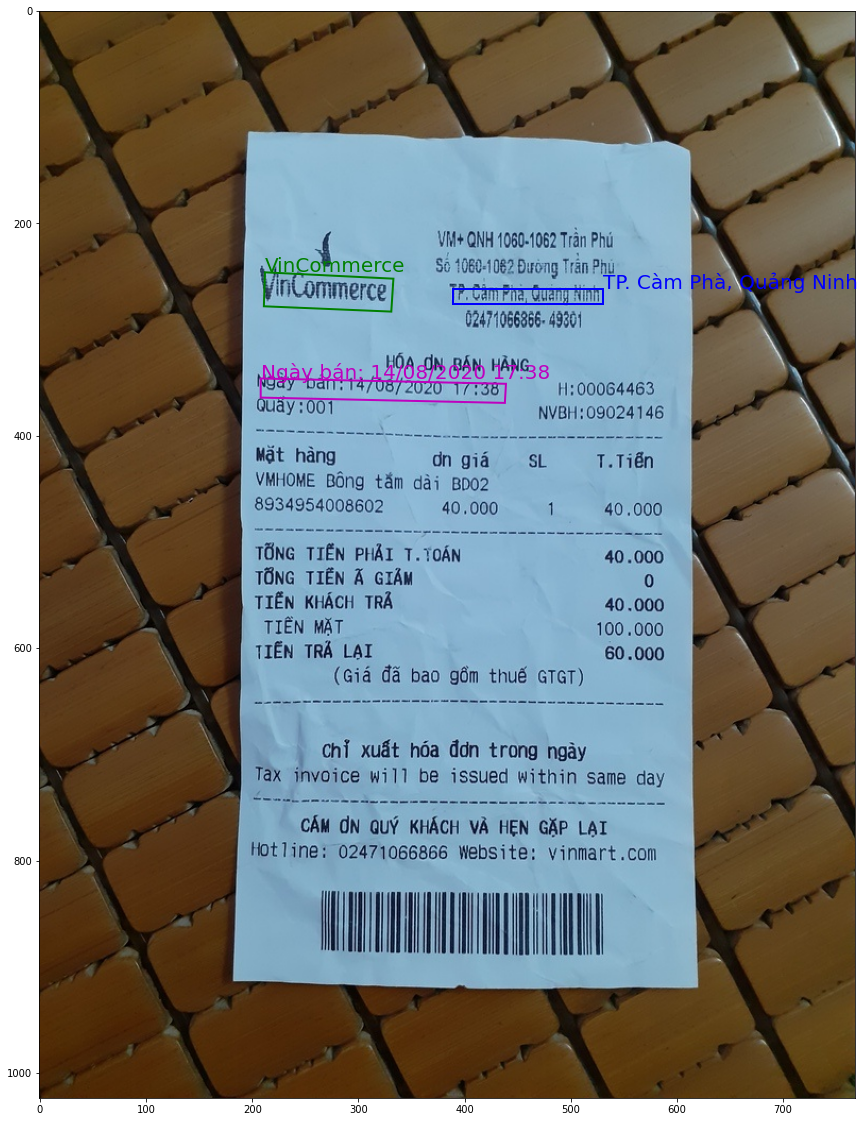

In [ ]:
color_map = {1: 'r', 15: 'green', 16: 'blue', 17: 'm', 18: 'cyan'}
viz_output_of_pick(img_dir="/content/test_output/key_info_extraction/test/images",
                           output_txt_dir="/content/test_output/key_info_extraction/test/txt",
                           output_viz_dir="/content/test_output/key_info_extraction/test/viz_imgs")